<a href="https://colab.research.google.com/github/jasp27/ds4bme_intro_p1/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Fit a pytorch model to the oasis data that treats gold lesions as the outcome and T2 value as the predictor. Use a bias term, sigmoid output activation function and no hidden layers. Do not split the data into a testing and training dataset. Demonstrate that the fitted values are the same as those obtained with logistic regression.



In [3]:
import pandas as pd
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Read in the data and display a few rows
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

In [5]:
## Create a binary outcome variable 
dat = dat.assign(y = dat.GOLD_Lesions)
## Create a normalized regression variable
dat = dat.assign(x = (dat.T2 - np.mean(dat.T2)) / np.std(dat.T2))
dat.head()

,FLAIR,PD,T1,T2,FLAIR_10,PD_10,T1_10,T2_10,FLAIR_20,PD_20,T1_20,T2_20,GOLD_Lesions,y,x
0,1.143692,1.586219,-0.799859,1.634467,0.437568,0.823800,-0.002059,0.573663,0.279832,0.548341,0.219136,0.298662,0,0,1.466353
1,1.652552,1.766672,-1.250992,0.921230,0.663037,0.880250,-0.422060,0.542597,0.422182,0.549711,0.061573,0.280972,0,0,0.534121
2,1.036099,0.262042,-0.858565,-0.058211,-0.044280,-0.308569,0.014766,-0.256075,-0.136532,-0.350905,0.020673,-0.259914,0,0,-0.746050
3,1.037692,0.011104,-1.228796,-0.470222,-0.013971,-0.000498,-0.395575,-0.221900,0.000807,-0.003085,-0.193249,-0.139284,0,0,-1.284565
4,1.580589,1.730152,-0.860949,1.245609,0.617957,0.866352,-0.099919,0.384261,0.391133,0.608826,0.071648,0.340601,0,0,0.958099


In [6]:
fit = smf.logit('y ~ x', data = dat).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Oct 2022   Pseudo R-squ.:                0.008262
Time:                        20:48:20   Log-Likelihood:                -68.742
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                    0.2845
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.201      0.002      0.998      -0.394       0.395
x              0.2159      0.204      1.061      0.289      -0.183       0.615
==============================================================================
"""

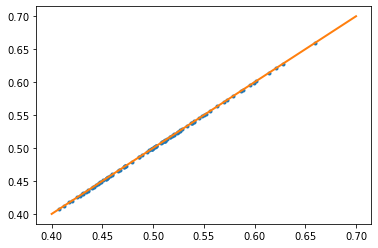

In [7]:
yhat = 1 / (1 + np.exp(-fit.fittedvalues))
n = dat.shape[0]

## Get the y and x from 
xtraining = torch.from_numpy(dat['x'].values)
ytraining = torch.from_numpy(dat['y'].values)

## PT wants floats
xtraining = xtraining.float()
ytraining = ytraining.float()

## Dimension is 1xn not nx1
## squeeze the second dimension
xtraining = xtraining.unsqueeze(1)
ytraining = ytraining.unsqueeze(1)

## Show that everything is the right size
[xtraining.shape, 
 ytraining.shape,
 [n, 1]
 ]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias = True)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

## Then the model is simply  
model = LogisticRegression()

## MSE is the loss function
loss_fn = torch.nn.BCELoss()  

## Set the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

## Loop over iterations
for t in range(100000):

  ## Forward propagation
  y_pred = model(xtraining)

  ## the loss for this interation
  loss = loss_fn(y_pred, ytraining)

  #print(t, loss.item() / n)

  ## Zero out the gradients before adding them up 
  optimizer.zero_grad()
  
  ## Backprop
  loss.backward()
  
  ## Optimization step
  optimizer.step()

ytest = model(xtraining)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest,  ".")
plt.plot([0.4, 0.7], [0.4, 0.7], linewidth=2)

In [8]:
for param in model.parameters():  
  print(param.data)

tensor([[0.2159]])
tensor([0.0005])


2. Fit a pytorch neural network with two hidden layers on the diamond dataset from the previous project predicting price. Evaluate your predictions on held out test set data.

In [4]:
diamond = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv")
y = torch.from_numpy(diamond[['price']].values)
dnew = diamond.drop(['table', 'depth', 'price','x','y','z'], axis=1)
x = pd.get_dummies(dnew)


In [5]:
trainFraction = .75

sample = np.random.uniform(size = len(y)) < trainFraction
trainingDat = diamond[sample]
testingDat = diamond[~sample]

x = torch.tensor(x.values)
y = torch.tensor(y)

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

[
 xtraining.size(),
 ytraining.size(),
 xtesting.size(),
 ytesting.size(),
]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[torch.Size([40600, 21]),
 torch.Size([40600, 1]),
 torch.Size([13340, 21]),
 torch.Size([13340, 1])]

In [6]:
xtraining = xtraining.float()
xtesting = xtesting.float()
ytraining = ytraining.float().unsqueeze(1)
ytesting = ytesting.float().unsqueeze(1)

H1 = 6
H2 = 3

## Number of predictors
D_in = xtraining.shape[1]
D_out = 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-10
for t in range(1000):
    y_pred = model(xtraining)
    loss = loss_fn(y_pred, ytraining)
    if t % 100 == 0:
        print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

ytesting_pred = model(xtesting)
a = ytesting_pred.detach().numpy()

plt.scatter(a[:,0], ytesting[:,0], ".")


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([40600, 1, 1])) that is different to the input size (torch.Size([40600, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 5.133252999879066e+16


KeyboardInterrupt: ignored

In [ ]:
plt.title('Fitted vs Test Data')
plt.xlabel('Fitted Values')
plt.ylabel('Test Data')
